In [1]:
from typing import Union, Tuple, Optional

import matplotlib.pyplot as plt
import torch
from PIL import Image
from diffusers import StableDiffusionPipeline, DDIMInverseScheduler, AutoencoderKL, DDIMScheduler,DPMSolverMultistepScheduler
from torchvision import transforms as tvt

/root/miniconda3/envs/sid/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# model_id = "stabilityai/stable-diffusion-2-1"

# # Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
# pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
# # pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
# pipe = pipe.to("cuda")

# prompt = "a photo of an astronaut riding a horse on mars"
# image = pipe(prompt).images[0]
# image
# image.save("astronaut_rides_horse.png")


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dtype = torch.float16

inverse_scheduler = DDIMInverseScheduler.from_pretrained('stabilityai/stable-diffusion-2-1', subfolder='scheduler')
pipe = StableDiffusionPipeline.from_pretrained('stabilityai/stable-diffusion-2-1',
                                                scheduler=inverse_scheduler,
                                                safety_checker=None,
                                                torch_dtype=dtype)
pipe.to(device)
vae = pipe.vae
input_image_prompt = "Photograph of a puppy on the grass"

/root/miniconda3/envs/sid/lib/python3.9/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
The config attributes {'skip_prk_steps': True} were passed to DDIMInverseScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


In [4]:
def load_image(imgname: str, target_size: Optional[Union[int, Tuple[int, int]]] = None) -> torch.Tensor:
    pil_img = Image.open(imgname).convert('RGB')
    if target_size is not None:
        if isinstance(target_size, int):
            target_size = (target_size, target_size)
        pil_img = pil_img.resize(target_size, Image.Resampling.LANCZOS)
    return tvt.ToTensor()(pil_img)[None, ...]  # add batch dimension


def img_to_latents(x: torch.Tensor, vae: AutoencoderKL):
    x = 2. * x - 1.
    posterior = vae.encode(x).latent_dist
    latents = posterior.mean * 0.18215
    return latents


@torch.no_grad()
def ddim_inversion(imgname: str, num_steps: int = 50, verify: Optional[bool] = False) -> torch.Tensor:
    input_img = load_image(imgname).to(device=device, dtype=dtype)
    latents = img_to_latents(input_img, vae)

    inv_latents, _ = pipe(prompt="", negative_prompt="", guidance_scale=1.,
                          width=input_img.shape[-1], height=input_img.shape[-2],
                          output_type='latent', return_dict=False,
                          num_inference_steps=num_steps, latents=latents)

    # verify
    if verify:
        pipe.scheduler = DDIMScheduler.from_pretrained('stabilityai/stable-diffusion-2-1', subfolder='scheduler')
        image = pipe(prompt="Photograph of a puppy on the grass", negative_prompt="", guidance_scale=1.,
                     num_inference_steps=num_steps, latents=inv_latents)
         # 保存生成的图像

        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(tvt.ToPILImage()(input_img[0]))
        ax[1].imshow(image.images[0])
        plt.show()
    return inv_latents


100%|██████████| 250/250 [00:20<00:00, 12.37it/s]


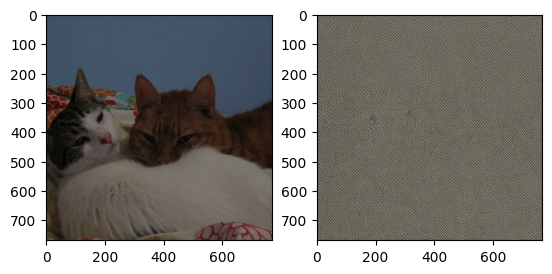

100%|██████████| 50/50 [00:07<00:00,  6.50it/s]


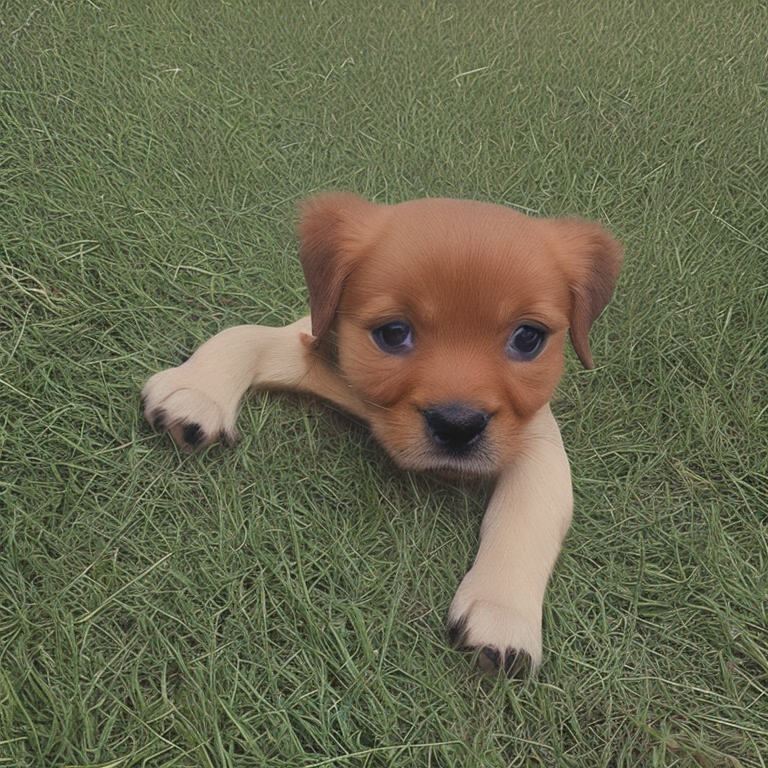

In [5]:
inverted_latents = ddim_inversion('data/cnt/00.png', num_steps=250, verify=True)
image = pipe(input_image_prompt, latents=inverted_latents[-1][None], num_inference_steps=50, guidance_scale=3.5).images[0]
image